<a href="https://colab.research.google.com/github/aryan-cs/aryan-cs.github.io/blob/master/sail-comp-vis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this Colab notebook, you will follow along as we create and train a simple neural network, a specific type of machine learning model, for recognizing digits in images. We are using the MNIST Digit Recoginition dataset to train and test our model.

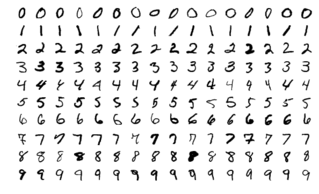

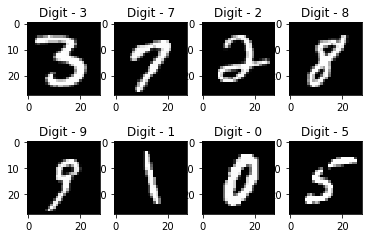

As you can see, this dataset contains many different images of handwritten digits from 0 - 9. Each image has an obvious, correct output number associated with it for training. The goal of our machine learning model is to be able to predict the correct number from these images.


# Imports

First, we'll need to import a few necessary libraries to help build our machine learning model:

* torch - PyTorch is an open source machine learning framework which we will use to build and develop our neural network. 

* sklearn - scikit-learn is another free machine learning library from which we will use utilities from to load and split our data.

* numpy - numpy is a useful library for handling operations with matrices and arrays, which we'll need for storing input and output data.

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import numpy as np

from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import cv2

# Define classes

Here, we define the Network class, a simple neural network created using PyTorch's nn module. 

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

        # initialize with normal distribution
        nn.init.normal_(self.conv1.weight, mean=0.0, std=1.0)
        nn.init.normal_(self.conv2.weight, mean=0.0, std=1.0)
        nn.init.normal_(self.fc1.weight, mean=0.0, std=1.0)
        nn.init.normal_(self.fc2.weight, mean=0.0, std=1.0)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

We also define train and test functions. The train function is where we have the model loop through the train dataset and attempt to improve its peformance. Then we evaluate this improvement on the test dataset. 

In [ ]:
def train(model, device, train_loader, loss_function, optimizer, epoch):
    model.train()
    loss_array = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        if loss_function == 'nll_loss':
            train_loss = F.nll_loss(output, target)
        elif loss_function == 'cross_entropy':
            train_loss = F.cross_entropy(output, target)
        else:
            assert(False) # invalid loss function
        loss_array.append(train_loss.item())
        train_loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), train_loss.item()))
    return loss_array

In [ ]:
def test(model, device, test_loader, loss_function):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            if loss_function == 'nll_loss':
                test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            elif loss_function == 'cross_entropy':
                test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            else:
                assert(False) # invalid loss function
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Below, we define our batch size parameters. The batch size determines the number of samples we use from the training set to update our model. With a batch size of 4096, we would pull 4096 examples from the dataset to make an update, then pull another 4096, until we've gone through the entire dataset. Also note that we have purposefully given you poor choices for these parameters, and it is up to you to improve them to get a good accuracy. 

In [ ]:
#@title Batch Size

# Change these!
train_batch_size = 4096 #@param {type: "integer"}
test_batch_size = 1024 #@param {type: "integer"}



Now, let's actually define the dataset. Pytorch has built in functions that allow us to load in the MNIST dataset. The dataset has input training examples and the correct digits associated with those input images. We also define a test dataset which allows us to test the accuracy of our model. 

In [ ]:
transform=transforms.Compose([
        transforms.ToTensor()
        ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=train_batch_size)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=test_batch_size)


# Train model

Now, we can finally start training our model! 


We first define the hyperparameters learning rate and epochs. 


Learning rate determines how fast our model converges and accepts input / output examples. Too fast a learning rate and our model doesn't properly train to make the best predictions. Too slow and the model will potentially overfit, basically overcomplicating its predictions. 


The number of epochs is the number of passes the training data makes through the algorithm. The more epochs, our model will be able to train on more data albeit taking more time. 


Feel free to play around with these training parameters and see how they affect the loss of our model. 

In [ ]:
#@title Learning Rate and Epochs

# Change these!
learning_rate = 0.5 #@param {type:"number"}
epochs = 1 #@param {type: "integer"}

We want to use a GPU if it is available as it will train faster, however if not we want to use CPU. Let us know if you run into any issues with this. 

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

In [ ]:
model = Network().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
error = 'nll_loss'
loss_array = []

for epoch in range(1, epochs + 1):
    epoch_loss = train(model, device, train_loader, error, optimizer, epoch)
    loss_array.extend(epoch_loss)
    test(model, device, test_loader, error)

plt.plot(loss_array)
plt.title("Loss vs Mini Batches")
plt.xlabel("Mini Batch Number")
plt.ylabel("Loss")
plt.show()

#Test Your Model!

Now, let's try testing your model with some images in the testing set. Take a look in the output figure to see if there are any incorrect classifications (in red). 

Feel free to change the size of the figure, though the plot may break if you set it too large!

In [ ]:
transform = transforms.ToPILImage()


# setting values to rows and column variables
rows = 10
columns = 20
  
# create figure
fig = plt.figure(figsize=(columns, rows))

# make sure we have enough images to show
# we pick a random set of images each time
assert rows * columns < len(dataset2)
images_idx = np.floor(np.random.rand(rows * columns) * len(dataset2)).astype(int)


# reading images
for idx, image_idx in enumerate(images_idx):
  tensor = dataset2[image_idx][0]
  img = transform(tensor)
  # run image through model
  input = dataset2[image_idx][0].to(device).unsqueeze(1)
  output = model(input)
  output_data = output.cpu().detach().numpy()[0]
  max_val = -torch.inf
  max_index = 0
  for i in range(0,10):
      if (output_data[i] > max_val):
          max_val = output_data[i]
          max_index = i
  correct = max_index == dataset2[image_idx][1]
  # Adds a subplot at the ith position
  ax = fig.add_subplot(rows, columns, idx + 1)
  ax.text(0, 0, "Prediction: " + str(max_index), fontsize = 7.15,
        bbox={'facecolor': 'white' if correct else 'red', 'alpha': 1, 'pad': 1})
  ax.imshow(img)
  ax.axis('off')

#Extra (Take Home)
If you finish early, you can try training this model on the Fashion MNIST dataset. Instead of digits, Fashion MNIST classifies clothing articles.


In [ ]:
from IPython.display import Image
display(Image(url='https://i.imgur.com/RoSdrMa.png', width=500))
display(Image(url='https://i.imgur.com/re6R8cX.png', width=500))

Let's start by adding a few extra imports:

In [ ]:
import pandas as pd
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics
from itertools import chain 

We define our train and test batch sizes

In [ ]:
#@title Batch Size

# Change these!
train_batch_size = 4096 #@param {type: "integer"}
test_batch_size = 1024 #@param {type: "integer"}



#Download Dataset
Download the Fashion MNIST dataset.

In [ ]:
transform=transforms.Compose([
        transforms.ToTensor()
        ])
fashion_train = datasets.FashionMNIST('../data', train=True, download=True,
                transform=transform)
fashion_test = datasets.FashionMNIST('../data', train=False,
                transform=transform)
train_loader = torch.utils.data.DataLoader(fashion_train, batch_size=train_batch_size)
test_loader = torch.utils.data.DataLoader(fashion_test, batch_size=test_batch_size)

To make it easier for us to look up the type of clothing from the outputted number, we create a small helper function to do this.

In [ ]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

We define the model here. Since the task is a bit more complex, we use more layers

In [ ]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

        # initialize with normal distribution
        nn.init.normal_(self.layer1[0].weight, mean=0.0, std=1.0)
        nn.init.normal_(self.layer2[0].weight, mean=0.0, std=1.0)
        nn.init.normal_(self.fc1.weight, mean=0.0, std=1.0)
        nn.init.normal_(self.fc2.weight, mean=0.0, std=1.0)
        nn.init.normal_(self.fc3.weight, mean=0.0, std=1.0)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [ ]:
#@title Learning Rate and Epochs

# Change these!
learning_rate = 0.1 #@param {type:"number"}
epochs = 1 #@param {type: "integer"}

##Setup model

In [ ]:
model = FashionCNN()
model.to(device)

error = 'cross_entropy'

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

##Training

In [ ]:
# Lists for knowing classwise accuracy
loss_array = []

for epoch in range(epochs):
    epoch_loss = train(model, device, train_loader, error, optimizer, epoch)
    loss_array.extend(epoch_loss)
    test(model, device, test_loader, error)

plt.plot(loss_array)
plt.title("Loss vs Mini Batches")
plt.xlabel("Mini Batch Number")
plt.ylabel("Loss")
plt.show()

#Testing

Now, let's try testing your model with some images in the testing set. Take a look in the output figure to see if there are any incorrect classifications (in red). 

Feel free to change the size of the figure, though the plot may break if you set it too large!

In [ ]:
transform = transforms.ToPILImage()


# setting values to rows and column variables
rows = 10
columns = 20
  
# create figure
fig = plt.figure(figsize=(columns, rows))

# make sure we have enough images to show
# we pick a random set of images each time
assert rows * columns < len(fashion_test)
images_idx = np.floor(np.random.rand(rows * columns) * len(fashion_test)).astype(int)


# reading images
for idx, image_idx in enumerate(images_idx):
  tensor = fashion_test[image_idx][0]
  img = transform(tensor)
  # run image through model
  input = fashion_test[image_idx][0].to(device).unsqueeze(1)
  output = model(input)
  output_data = output.cpu().detach().numpy()[0]
  max_val = -torch.inf
  max_index = 0
  for i in range(0,10):
      if (output_data[i] > max_val):
          max_val = output_data[i]
          max_index = i
  correct = max_index == fashion_test[image_idx][1]
  # Adds a subplot at the ith position
  ax = fig.add_subplot(rows, columns, idx + 1)
  ax.text(0, 0, str(output_label(max_index)), fontsize = 9,
        bbox={'facecolor': 'white' if correct else 'red', 'alpha': 1, 'pad': 1})
  ax.imshow(img)
  ax.axis('off')

#Class Accuracy
Let's see if there are any particular classes that your model is struggling or excelling at!

In [ ]:
class_correct = np.zeros(10).astype(float)
total_correct = np.zeros(10).astype(float)

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(100):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(10):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))